# Eaton method with well log

Pore pressure prediction with Eaton's method using well log data.

Steps:

1. Calculate Velocity Normal Compaction Trend

2. Optimize for Eaton's exponent n

3. Predict pore pressure using Eaton's method

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# for python 2 and 3 compatibility
# from builtins import str
# try:
#     from pathlib import Path
# except:
#     from pathlib2 import Path
#--------------------------------------------
import sys
ppath = "../.."

if ppath not in sys.path:
    sys.path.append(ppath)
#--------------------------------------------

In [2]:
from __future__ import print_function, division, unicode_literals
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use(['seaborn-paper', 'seaborn-whitegrid'])
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

import numpy as np

import pygeopressure as ppp

## 1. Calculate Velocity Normal Compaction Trend

Create survey with the example survey `CUG`:

In [3]:
# set to the directory on your computer
SURVEY_FOLDER = "C:/Users/yuhao/Desktop/CUG_depth"

survey = ppp.Survey(SURVEY_FOLDER)

Retrieve well `CUG1`:

In [4]:
well_cug1 = survey.wells['CUG1']

Get velocity log:

In [5]:
vel_log = well_cug1.get_log("Velocity")

View velocity log:

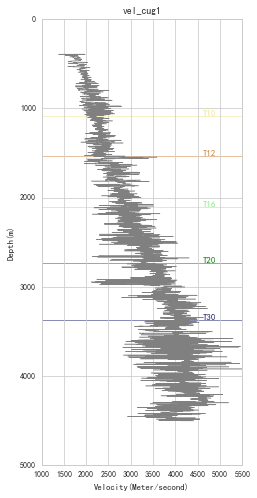

In [6]:
fig_vel, ax_vel = plt.subplots()
ax_vel.invert_yaxis()
vel_log.plot(ax_vel)
well_cug1.plot_horizons(ax_vel)

# set fig style
ax_vel.set(ylim=(5000,0), aspect=(5000/4600)*2)
ax_vel.set_aspect(2)
fig_vel.set_figheight(8)

Optimize for NCT coefficients a, b:

`well.params['horizon']['T20']` returns the depth of horizon T20.

In [7]:
a, b = ppp.optimize_nct(
    vel_log=well_cug1.get_log("Velocity"),
    fit_start=well_cug1.params['horizon']["T16"],
    fit_stop=well_cug1.params['horizon']["T20"])

And use a, b to calculate normal velocity trend

In [8]:
from pygeopressure.velocity.extrapolate import normal_log
nct_log = normal_log(vel_log, a=a, b=b)

View fitted NCT:

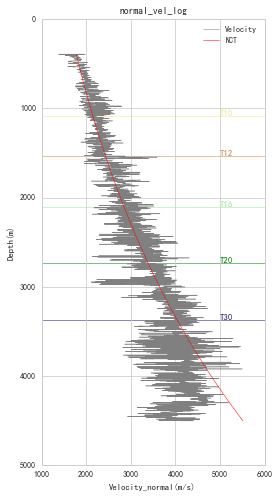

In [9]:
fig_vel, ax_vel = plt.subplots()
ax_vel.invert_yaxis()
# plot velocity
vel_log.plot(ax_vel, label='Velocity')
# plot horizon
well_cug1.plot_horizons(ax_vel)
# plot fitted nct
nct_log.plot(ax_vel, color='r', zorder=2, label='NCT')

# set fig style
ax_vel.set(ylim=(5000,0), aspect=(5000/4600)*2)
ax_vel.set_aspect(2)
ax_vel.legend()
fig_vel.set_figheight(8)

Save fitted nct:

In [10]:
# well_cug1.params['nct'] = {"a": a, "b": b}

# well_cug1.save_params()

## 2. Optimize for Eaton's exponent n

First, we need to preprocess velocity.

Velocity log processing (filtering and smoothing):

In [11]:
vel_log_filter = ppp.upscale_log(vel_log, freq=20)

vel_log_filter_smooth = ppp.smooth_log(vel_log_filter, window=1501)

Veiw processed velocity:

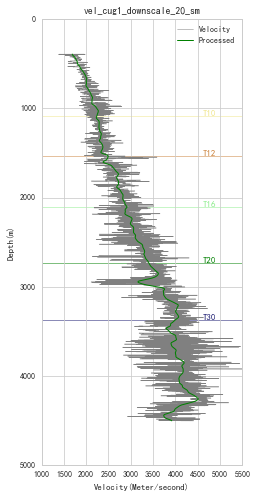

In [12]:
fig_vel, ax_vel = plt.subplots()
ax_vel.invert_yaxis()
# plot velocity
vel_log.plot(ax_vel, label='Velocity')
# plot horizon
well_cug1.plot_horizons(ax_vel)
# plot processed velocity
vel_log_filter_smooth.plot(ax_vel, color='g', zorder=2, label='Processed', linewidth=1)

# set fig style
ax_vel.set(ylim=(5000,0), aspect=(5000/4600)*2)
ax_vel.set_aspect(2)
ax_vel.legend()
fig_vel.set_figheight(8)

We will use the processed velocity data for pressure prediction.

Optimize Eaton's exponential `n`:

In [13]:
n = ppp.optimize_eaton(
    well=well_cug1, 
    vel_log=vel_log_filter_smooth, 
    obp_log="Overburden_Pressure", 
    a=a, b=b)

See the RMS error variation with `n`:

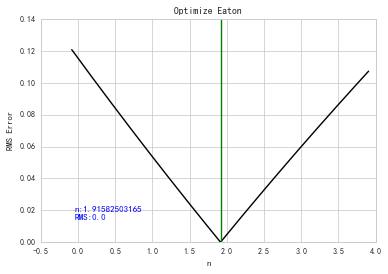

In [14]:
from pygeopressure.basic.plots import plot_eaton_error

fig_err, ax_err = plt.subplots()

plot_eaton_error(
    ax=ax_err,
    well=well_cug1, 
    vel_log=vel_log_filter_smooth, 
    obp_log="Overburden_Pressure", 
    a=a, b=b)

Save optimized n:

In [15]:
# well_cug1.params['nct'] = {"a": a, "b": b}

# well_cug1.save_params()

## 3.Predict pore pressure using Eaton's method

Calculate pore pressure using Eaton's method requires velocity, Eaton's exponential, normal velocity, hydrostatic pressure and overburden pressure.

`Well.eaton()` will try to read saved data, users only need to specify them when they are different from the saved ones.

In [16]:
pres_eaton_log = well_cug1.eaton(vel_log_filter_smooth, n=n)

View predicted pressure:

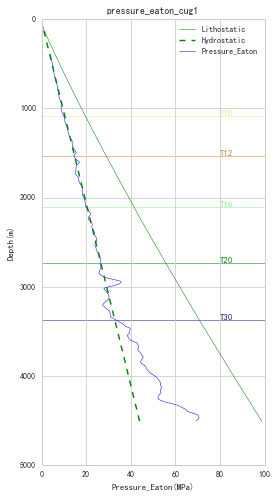

In [17]:
fig_pres, ax_pres = plt.subplots()
ax_pres.invert_yaxis()

well_cug1.get_log("Overburden_Pressure").plot(ax_pres, 'g', label='Lithostatic')
ax_pres.plot(well_cug1.hydrostatic, well_cug1.depth, 'g', linestyle='--', label="Hydrostatic")
pres_eaton_log.plot(ax_pres, color='blue', label='Pressure_Eaton')
well_cug1.plot_horizons(ax_pres)

# set figure and axis size
ax_pres.set_aspect(2/50)
ax_pres.legend()
fig_pres.set_figheight(8)